# Tensorboard runs
To explore the results of the grid search, one can use tensorboard with the following command `tensorboard --logdir="../grid_search_tensorboard"

# VAE
The following code chunk will not make the model training. It is used only for splitting the dataset into training and test set, so I can plot some graphs and use the test set for downstream analyses, i.e. the comparison of PCA vs VAE.
To run the model and the training, one can just launch the `vae.py` script passing the required options, as described in the argparse.

In [2]:
#!/usr/bin/env python
"""pop_embedding.py: Implementation of VAEs for the origins v44.3 dataset"""


# Basic libraries
import os
import numpy as np
import pickle
import pandas as pd
import re
# Torch dependencies
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import argparse
# Custom methods
from pytorch_loading import SNPLoading
from preprocess_vae import one_hot_encoding, metadata_mapping, split_train_test, impute_data, get_enc_dict, loss_ignore_nans
from vae_out import de_encoding

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# import seaborn as sns
import numpy as np
# import colorcet as cc
from mpl_toolkits.mplot3d import Axes3D

from torch.utils.tensorboard import SummaryWriter

##################################################

# Hyperparams 
CUDA = torch.cuda.is_available()
SEED = 42 #Replace with your value
BATCH_SIZE = 30 #Replace with your value 
EPOCHS = 1 #Replace with your value
ZDIMS = 2 #Replace with your value (Dimensions of latent space)
TRAIN = 0.8 #Replace with your value (proportion of samples to keep on training set)
HIDDEN_UNITS = 100 #Replace with your value (Units per layer)
HIDDEN_LAYERS = 2 #Replace with your value (Amount of hidden layers)


# I save the date and the hour
now = datetime.now()
date_string = now.strftime("%d_%m_%Y_%H_%M")

# I save the experiment ID with the hyperparameters set and the date at the end
experiment_id = f"hunits{HIDDEN_UNITS}_hlayers{HIDDEN_LAYERS}_epochs{EPOCHS}_batchsize{BATCH_SIZE}_zdims{ZDIMS}_trainprop{TRAIN}_{date_string}"

# Set seed to GPU
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# Allow use of GPU memory
device = torch.device("cuda" if CUDA else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

#####################################
### Map metadata to observations  ###
#####################################

# Get files path
data_files_path = "../tensor_data/"
files = os.listdir(data_files_path)
files.sort()

# Map metadata to sample encodings/name to get labels
encodings_file = data_files_path+files[0]
metadata_path = "../metadata/v44_metadata_clear.tsv"

# Remove encoding file and variants file
X = files[1:-1] 
features = files[-1]

##########################################
### Solve problem of unsorted patients ###
##########################################

# I remove the "_patient.pt" at the end of each patient string and I convert it to integer
stripped_integers = [int(i.rstrip("_patient.pt")) for i in X]
# I sort it numerically, so from 1 to 6155
stripped_integers.sort()

# I reconvert the patients number in string and concatenate with "_patient.pt"
X = [str(i) + "_patient.pt" for i in stripped_integers]

# Contains the 6155 targets e.g. ['Africa', 'North Asia', 'South East Europe'] etc
targets = metadata_mapping(X, metadata_path)
#########################################
### Encode targets : One-hot-encoding ###
#########################################

original_targets = np.array(targets)
targets = one_hot_encoding(targets)

# Make encoding dict to map encoding to original target
dict_encoding = get_enc_dict(original_targets, targets)
with open('../results/enc_dict', 'wb') as handle:
    pickle.dump(dict_encoding, handle)

###################################
## Partition train and test set ###
###################################

X_train, X_test, y_train, y_test = split_train_test(X, targets, 0.8)

train_set = SNPLoading(data_path=data_files_path, data_files=X_train, targets=y_train)
test_set = SNPLoading(data_path=data_files_path, data_files=X_test, targets=y_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

##################
### VAE Module ###
##################

# Get input features and encoding len of targets
## train_set[0] takes the first element of the training set, consisting of a tuple of two tensors: the X and the Y
## train_set[0][0] selects the X, i.e. the SNPs encoded as [0,0], [0,1], or [1,1]
## train_set[0][0].shape[0] tales the number of features, i.e. of SNPs (109348)
input_features = train_set[0][0].shape[0]
target_enc_len = targets.shape[1]

In [3]:
y_train_list = de_encoding(y_train, dict_encoding)
y_test_list = de_encoding(y_test, dict_encoding)

## Classes distribution in dataset
Code to plot the classes distribution of the entire dataset

<AxesSubplot:>

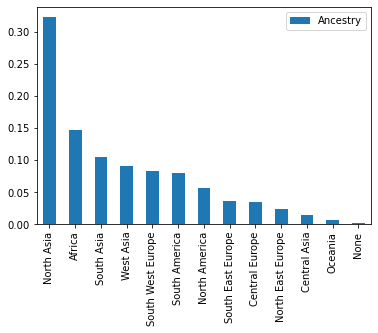

In [4]:
targets_ancestries = de_encoding(targets, dict_encoding)
# print(targets_ancestries)

targets_ancestries_df = pd.DataFrame(targets_ancestries)
# I rename the column name
targets_ancestries_df = targets_ancestries_df.rename(columns ={0 : "Ancestry"})

# print(y_train_df)
targets_ancestries_df = pd.DataFrame(
    targets_ancestries_df
    .Ancestry
    .value_counts(normalize=True)
)
targets_ancestries_df.plot.bar()

## Classes distribution in train and test set
The distribution of the classes is more or less the same

<AxesSubplot:>

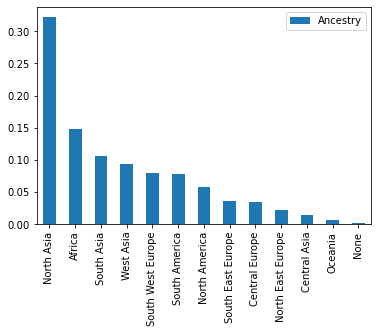

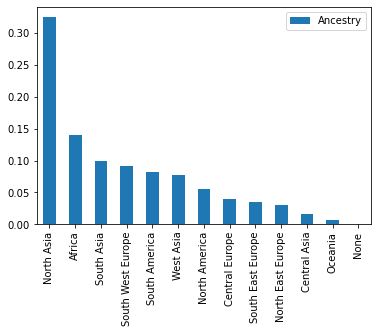

In [4]:
y_train_df = pd.DataFrame(y_train_list)
# I rename the column name
y_train_df = y_train_df.rename(columns ={0 : "Ancestry"})

# print(y_train_df)
y_train_df_distr = pd.DataFrame(
    y_train_df
    .Ancestry
    .value_counts(normalize=True)
)
y_train_df_distr.plot.bar()

y_test_df = pd.DataFrame(y_test_list)
# I rename the column name
y_test_df = y_test_df.rename(columns ={0 : "Ancestry"})

# print(y_train_df)
y_test_df_distr = pd.DataFrame(
    y_test_df
    .Ancestry
    .value_counts(normalize=True)
)
y_test_df_distr.plot.bar()

##


# PCA
I plot the PCs from the file that Felix sent us, after keeping only the first 2 so that the file was lighter to upload it to github.

1231


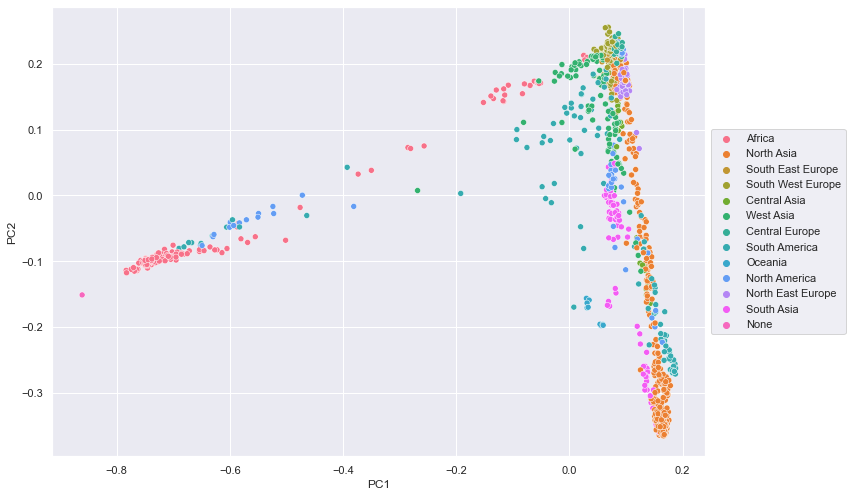

In [6]:
import pandas as pd
import seaborn as sns

# I read the principal components file and the metadata files
pcs = pd.read_csv("../metadata/first_pcs.txt", sep = "\t")
metadata = pd.read_csv("../metadata/v44_metadata_clear.tsv", sep = "\t", names=["index", "index2", "encoding", "encoding2", "time_num", "time_str", "Country", "SNP_cov", "SNP_cov2", "SNP_cov3", "Annotated_ancestry"])

# I choose only the two columns I need and I rename the column encoding to IID
iid_ancestry_mapping = (metadata
.filter(["index", "encoding", "Annotated_ancestry"])
.rename(columns={"encoding" : "IID"})
)

# I left join the two dataframes
pcs = pd.merge(pcs, iid_ancestry_mapping, on = "IID")


print(len(X_test))
# I extract the patient numbers of the test set
test_patients_stripped = [int(i.rstrip("_patient.pt")) for i in X_test]

# I query only those rows (patients) whose index is in the test patients
pcs = (pcs
.query("index in @test_patients_stripped")
)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = pcs, x = "PC1", y ="PC2", hue = "Annotated_ancestry")
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))



# Latent spaces projection
Plotting of the latent spaces computed by the best VAE

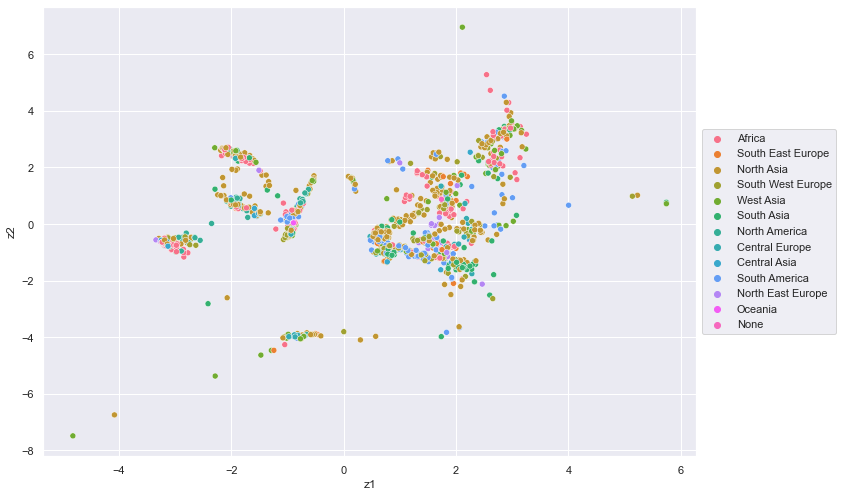

In [7]:
# I load the latent spaces of the TEST set of the best model
dataset = pd.read_csv("../results/batchnorm_hunits100_hlayers2_epochs50_batchsize30_zdims2_trainprop0.8_02_01_2022_14_12/latent_epoch50.csv")

dataset = dataset.rename(columns = {"label" : "Annotated_ancestry"})

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = dataset, x = "z1", y ="z2", hue = "Annotated_ancestry")
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))


I double check that the pcs and the dataset files have exactly the same ancestry distributions

In [8]:
print(pcs["Annotated_ancestry"].value_counts())
print(dataset["Annotated_ancestry"].value_counts())

North Asia           400
Africa               173
South Asia           123
South West Europe    112
South America        101
West Asia             95
North America         68
Central Europe        49
South East Europe     43
North East Europe     38
Central Asia          19
Oceania                9
None                   1
Name: Annotated_ancestry, dtype: int64
North Asia           400
Africa               173
South Asia           123
South West Europe    112
South America        101
West Asia             95
North America         68
Central Europe        49
South East Europe     43
North East Europe     38
Central Asia          19
Oceania                9
None                   1
Name: Annotated_ancestry, dtype: int64


# Multiclass classifications


I load the dataset containing the latent spaces of the TEST set of the best model and I split it in training and test set

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

########################################################
## CHANGE THE FOLLOWING VARIABLE TO:
# - VAE: FOR PLOTTING THE LATENT REPRESENTATIONS
# - PCA: FOR PLOTTING THE PRINCIPAL COMPONENTS  
########################################################
which_dataset = "PCA"



if which_dataset == "VAE":
    print("Dataset chosen as Latent Spaces from VAE analysis")
    
    # I divide the dataset into X and Y
    X = dataset[["z1","z2"]]
    Y = dataset[["Annotated_ancestry"]]


elif which_dataset == "PCA":
    print("Dataset chosen as Principal Components from PCA analysis")
    X = pcs[["PC1","PC2"]]
    Y = pcs[["Annotated_ancestry"]]

else:
    print("Choose between VAE or PCA")


# print(X)
# print(Y)
# print(dataset)

# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


Dataset chosen as Principal Components from PCA analysis


I check the classes distribution. As we can see, they differ quite a bit, especially for the ancestries North Africa and Africa. To have more balanced train and test sets, we could run the sklearn function `train_test_split` with the option `stratify` but, unfortunately, in this case we have too few samples. I tried to run it with the `stratify` option but I got the following error message: `The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.`

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'North Asia'),
  Text(1, 0, 'Africa'),
  Text(2, 0, 'South Asia'),
  Text(3, 0, 'South West Europe'),
  Text(4, 0, 'South America'),
  Text(5, 0, 'West Asia'),
  Text(6, 0, 'North America'),
  Text(7, 0, 'Central Europe'),
  Text(8, 0, 'South East Europe'),
  Text(9, 0, 'North East Europe'),
  Text(10, 0, 'Central Asia'),
  Text(11, 0, 'Oceania')])

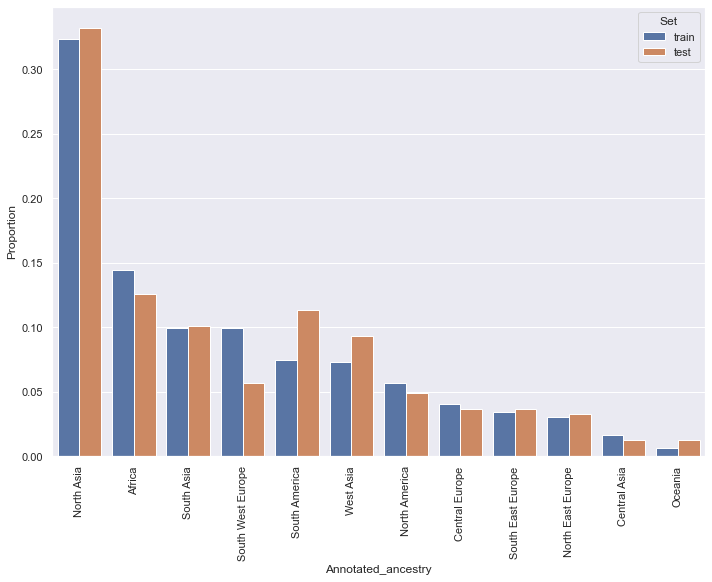

In [13]:
Y_train_distribution = pd.DataFrame(
    y_train
    .Annotated_ancestry
    .value_counts(normalize=True)
    .reset_index()
    .rename(columns={"Annotated_ancestry" : "train"})
)

Y_test_distribution = pd.DataFrame(
    y_test
    .Annotated_ancestry
    .value_counts(normalize=True)
    .reset_index()
    .rename(columns={"Annotated_ancestry" : "test"})
)

classes_distr = pd.merge(Y_train_distribution, Y_test_distribution, on = "index")
classes_distr = classes_distr.rename(columns={"index" : "Annotated_ancestry"})

classes_distr_melt = classes_distr.melt(id_vars = "Annotated_ancestry", var_name = "Set", value_name = "Proportion")


sns.barplot(x = "Annotated_ancestry", y = "Proportion", hue = "Set", data = classes_distr_melt)
plt.xticks(rotation=90)


## LogisticRegression

In [66]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train["Annotated_ancestry"])

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.33
Accuracy of Logistic regression classifier on test set: 0.32


## DecisionTreeClassifier

In [67]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train["Annotated_ancestry"])
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.29


## KNeighborsClassifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(np.array(X_train), np.ravel(y_train))
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(np.array(X_train), np.ravel(y_train))))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(np.array(X_test), np.ravel(y_test))))

Accuracy of K-NN classifier on training set: 0.56
Accuracy of K-NN classifier on test set: 0.35


## Confusion matrices

/Users/lmz306/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lmz306/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lmz306/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                   precision    recall  f1-score   support

           Africa       0.20      0.37      0.26        27
     Central Asia       0.00      0.00      0.00         7
   Central Europe       0.25      0.30      0.27        10
             None       0.00      0.00      0.00         1
    North America       0.50      0.39      0.44        18
       North Asia       0.44      0.56      0.49        78
North East Europe       0.25      0.12      0.17         8
          Oceania       0.50      0.50      0.50         2
    South America       0.27      0.20      0.23        20
       South Asia       0.36      0.38      0.37        24
South East Europe       0.00      0.00      0.00        10
South West Europe       0.36      0.22      0.28        18
        West Asia       0.36      0.17      0.23        24

         accuracy                           0.35       247
        macro avg       0.27      0.25      0.25       247
     weighted avg       0.34      0.35      0.33      

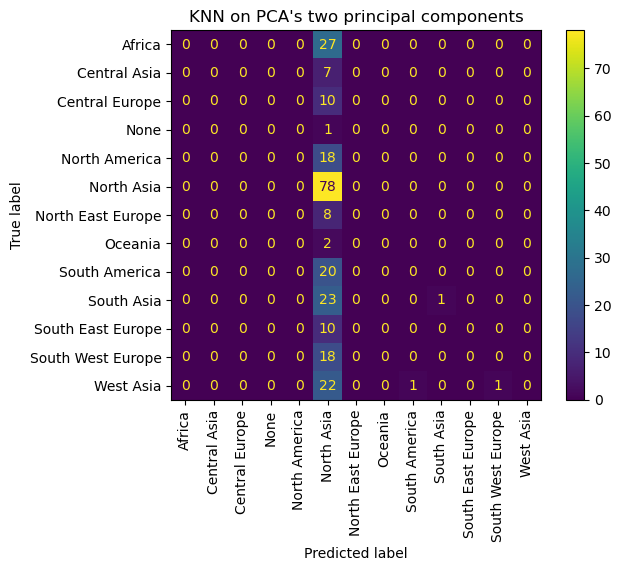

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plt.rcParams.update(plt.rcParamsDefault)

# LogisticRegression
# pred = logreg.predict(X_test)

# Decision tree
# pred = clf.predict(X_test)

# KNN
pred = knn.predict(X_test)

# print(confusion_matrix(y_test, pred))
plot_confusion_matrix(logreg, X_test, y_test)
plt.xticks(rotation=90)
# plt.title("Logistic regression on VAE's two latent representations")
# plt.title("Logistic regression on PCA's two principal components")
# plt.title("Decision tree on VAE's two latent representations")
# plt.title("Decision tree on PCA's two principal components")
# plt.title("KNN on VAE's two latent representations")
plt.title("KNN on PCA's two principal components")
# plt.show()
print(classification_report(y_test, pred))